In [9]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# Get the absolute path of the directory containing the notebook file
notebook_dir = os.path.dirname(os.path.abspath('__file__'))

# Navigate two levels up to reach the 'data_files' directory
data_files_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir, 'data_files'))

# Construct the path to the file
file_path = os.path.join(data_files_dir, 'HomeA-meter4_2016.csv')

# Load the dataset
df = pd.read_csv(file_path)

# Drop 'gen [kW]' and 'use [kW]' columns
df.drop(columns=['gen [kW]', 'use [kW]'], inplace=True)

# Define the path for the cleaned data folder
cleaned_data_folder = 'output_cleaned_dnn_data'

# Check if the cleaned data folder exists, if not, create it
if not os.path.exists(cleaned_data_folder):
    os.makedirs(cleaned_data_folder)

# Save the updated DataFrame to a new TXT file under the cleaned_data folder
dataset_output_file_path = os.path.join(cleaned_data_folder, 'DNN_HomeA-meter4_2016_updated.txt')

# Save the cleaned dataset under the cleaned_data directory
df.to_csv(dataset_output_file_path, sep='\t', index=True)



In [11]:
# Create a file to store the output
output_file = os.path.join(cleaned_data_folder, 'DNN_data_consistency_report.txt')

with open(output_file, 'w') as f:
    f.write("Original Dataset:\n")
    f.write(str(df.head()) + "\n\n")

    # Data Cleaning Steps
    # 1. Convert Date & Time column to datetime format
    df['Date & Time'] = pd.to_datetime(df['Date & Time'])

    # 2. Handle Missing Values (if any)
    # Check for missing values
    missing_values = df.isnull().sum()
    f.write("Missing Values:\n")
    f.write(str(missing_values) + "\n\n")

    # 3. Check Data Consistency
    # Check column data types
    f.write("Data Types:\n")
    f.write(str(df.dtypes) + "\n\n")

    # Range checks for numerical columns
    numerical_columns = df.select_dtypes(include=['float64']).columns
    f.write("Range Checks:\n")
    for col in numerical_columns:
        min_val = df[col].min()
        max_val = df[col].max()
        f.write(f"\nRange for {col}:\n")
        f.write(f"Min: {min_val}, Max: {max_val}\n")

    # Check unique values for categorical columns (if any)
    categorical_columns = df.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        f.write("\nUnique Values for Categorical Columns:\n")
        for col in categorical_columns:
            unique_values = df[col].unique()
            f.write(f"\n{col}:\n")
            f.write(str(unique_values) + "\n")

    # Temporal consistency: Check for duplicate timestamps
    duplicate_timestamps = df['Date & Time'].duplicated().sum()
    f.write("\nDuplicate Timestamps: " + str(duplicate_timestamps) + "\n\n")

print("Data consistency report completed. Report saved to:", output_file)


Data consistency report completed. Report saved to: output_cleaned_dnn_data/DNN_data_consistency_report.txt


In [12]:
# 4. Normalize Data

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select numerical columns to normalize
numerical_columns = df.select_dtypes(include=['float64']).columns

# Apply normalization to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print("Data normalization completed.")

Data normalization completed.


In [13]:
# 5. Outlier Detection

# Define a function to detect outliers using the interquartile range (IQR) method
def detect_outliers(df, threshold=1.5):
    outliers = []
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            Q1 = np.percentile(df[col], 25)
            Q3 = np.percentile(df[col], 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            # Print the calculated bounds for debugging
            print(f"Column: {col}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
            # Identify outliers and append their indices
            outliers.extend(df[(df[col] < lower_bound) | (df[col] > upper_bound)].index)
    return list(set(outliers))

# Detect outliers in the dataset
outlier_indices = detect_outliers(df)

# Remove outliers from the dataset
cleaned_df = df.drop(outlier_indices)


Column: KitchenDenLights [kW], Lower Bound: -0.3128392327915092, Upper Bound: 0.5678947104704457
Column: MasterBedBathLights [kW], Lower Bound: -0.0944027800629083, Upper Bound: 0.20594402855068955
Column: MasterOutlets [kW], Lower Bound: 0.0048460198730595535, Upper Bound: 0.006860590609229876
Column: DenOutdoorLights [kW], Lower Bound: 0.021921660038775007, Upper Bound: 0.03311568968067742
Column: DenOutlets [kW], Lower Bound: -0.00817198471581757, Upper Bound: 0.013792243486629092
Column: RearBasementLights [kW], Lower Bound: 0.034369575129533675, Upper Bound: 0.04127809326424872
Column: KitchenOutletsEast [kW], Lower Bound: 0.0019562340848806358, Upper Bound: 0.0023983189655172417
Column: KitchenOutletsSouth [kW], Lower Bound: 0.001181095369471238, Upper Bound: 0.001394225360954769
Column: DishwasherDisposalSinkLight [kW], Lower Bound: -0.024102477724538038, Upper Bound: 0.04443823664831721
Column: Refrigerator [kW], Lower Bound: -0.12487740679537304, Upper Bound: 0.222387919068155

In [14]:
# 6. Feature Engineering (if necessary)
# Extract additional temporal features: day of the week and hour of the day
cleaned_df['DayOfWeek'] = cleaned_df['Date & Time'].dt.dayofweek  # Monday=0, Sunday=6
cleaned_df['HourOfDay'] = cleaned_df['Date & Time'].dt.hour

# Sum the values in each row starting from 'KitchenDenLights [kW]' column and update 'Total Energy Demand' column
df['Total Energy Demand'] = df.iloc[:, 1:].sum(axis=1)

# Assuming 'Date & Time' is the name of your datetime column
df['Date & Time'] = pd.to_datetime(df['Date & Time'])

# Set the datetime column as the index
df.set_index('Date & Time', inplace=True)

# Now, you can proceed with resampling and plotting
df_weekly = df['Total Energy Demand'].resample('W').sum()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502743 entries, 2016-01-01 00:00:00 to 2016-12-31 23:59:00
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   KitchenDenLights [kW]             502743 non-null  float64
 1   MasterBedBathLights [kW]          502743 non-null  float64
 2   MasterOutlets [kW]                502743 non-null  float64
 3   DenOutdoorLights [kW]             502743 non-null  float64
 4   DenOutlets [kW]                   502743 non-null  float64
 5   RearBasementLights [kW]           502743 non-null  float64
 6   KitchenOutletsEast [kW]           502743 non-null  float64
 7   KitchenOutletsSouth [kW]          502743 non-null  float64
 8   DishwasherDisposalSinkLight [kW]  502743 non-null  float64
 9   Refrigerator [kW]                 502743 non-null  float64
 10  Microwave [kW]                    502743 non-null  float64
 11  OfficeLights [kW] 

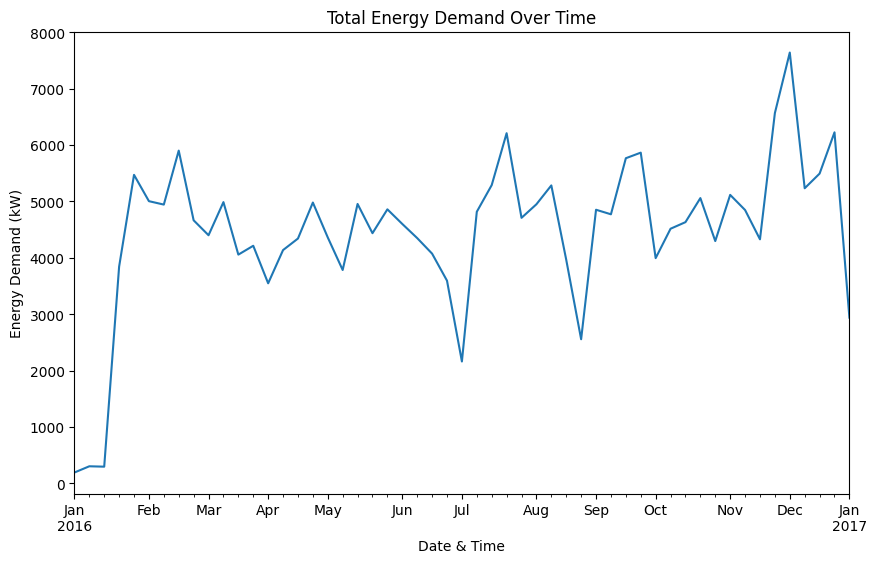

In [15]:
# Data Exploration
df.info()
print(df.head())

# Plot the total energy demand
df_weekly.plot(figsize=(10, 6))
plt.ylabel('Energy Demand (kW)')
plt.title('Total Energy Demand Over Time')
plt.show()


In [16]:
# Set the cleaned file path
cleaned_file_path = os.path.join(cleaned_data_folder, 'DNN_HomeA-meter4_2016_updated.txt')
cleaned_file_path_csv = os.path.join(cleaned_data_folder, 'DNN_HomeA-meter4_2016_updated.csv')

# Save the cleaned dataset under the cleaned_data directory
df.to_csv(cleaned_file_path, sep='\t', index=True)

df.to_csv(cleaned_file_path_csv, index=True)


df.head()

,KitchenDenLights [kW],MasterBedBathLights [kW],MasterOutlets [kW],DenOutdoorLights [kW],DenOutlets [kW],RearBasementLights [kW],KitchenOutletsEast [kW],KitchenOutletsSouth [kW],DishwasherDisposalSinkLight [kW],Refrigerator [kW],Microwave [kW],OfficeLights [kW],Total Energy Demand
Date & Time,,,,,,,,,,,,,
2016-01-01 00:00:00,0.018227,0.099599,0.015457,0.025498,0.001271,0.037812,0.002350,0.001943,0.001948,0.105713,0.002314,0.045191,0.357323
2016-01-01 00:15:00,0.018080,0.019319,0.015511,0.027239,0.001302,0.037605,0.002289,0.001939,0.001945,0.110827,0.002376,0.044987,0.283419
2016-01-01 00:30:00,0.018035,0.019061,0.014964,0.026866,0.001309,0.037835,0.002172,0.001974,0.001979,0.026544,0.002291,0.044845,0.197874
2016-01-01 00:45:00,0.018099,0.019002,0.015063,0.027736,0.001310,0.037628,0.002262,0.001949,0.001950,0.103128,0.002375,0.044855,0.275356
2016-01-01 01:00:00,0.018041,0.018991,0.014488,0.027674,0.001310,0.037789,0.002251,0.001950,0.001952,0.097399,0.002363,0.044872,0.269079
